# Data Cleaning & Modelling on PG&E Energy Consumption

This notebook is dedicated for cleaning the available energy data sets and brining them to format appropriate for regression modellings.

### Importing require packages:

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import re
import glob
from bokeh.io import push_notebook, output_notebook, show
from bokeh.plotting import figure
from bokeh.models import CategoricalColorMapper
from bokeh.models import ColumnDataSource
from bokeh.resources import Resources
import bokeh.plotting as bplt
from bokeh.resources import INLINE
import bokeh.io
bokeh.io.output_notebook(INLINE)
from bokeh.layouts import row, column
import seaborn as sns
sns.set(style='whitegrid', context='notebook')
from ggplot import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
import xgboost as xgb

Loading BokehJS ...

C:\ProgramData\Anaconda5\lib\site-packages\ggplot\utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
C:\ProgramData\Anaconda5\lib\site-packages\ggplot\stats\smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
C:\ProgramData\Anaconda5\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Data Explanation:

There are 40 csv files available, 20 for gas consumption and 20 for electricity consumption.
Data is available for all quarters for 5 years from 2013 to 2017.

The columns are:

- ``ZipCode``: the location of the energy customer
- ``Month``: month of the year
- ``Year``: year of measurement
- ``CustomerClass``: categorical with four levels (1) residential, (2) commercial, (3) agricultural, and (4) industrial.
- ``Combined``: If zipcode is not large enough. It is categorical with two class, Yes and No. 
- ``TotalCustomers``: number of customers consuming energy in that zip code.
- ``TotalKwh``: total KWh used **available for electrical energy data**
- ``TotalThm``: total gas usage ** available for gas energy data**

### Data Import

We use globe package to import the name of all the csv file into a list.

In [2]:
pattern_elec = 'data/*ElectricUsageByZip.csv'
pattern_gas = 'data/*GasUsageByZip.csv'
elec_csv_files = glob.glob(pattern_elec) # allows importing file name for wild cards
gas_csv_files = glob.glob(pattern_gas) # allows importing file name for wild cards

The following code block will perform this actions:
    
- Concatanating all the electricity data frames into one
- Lower casing the column names (some csv files have uppoer case column names)
- Cleaing customer class name to only contain industrial/commericial/residential/agricultural
- Cleaning total kiloWatt power into integer value
- Cleaning total number of customers into integer value
- Removing areas without customers [totalcustomers == 0]
- Getting the logarithm of the power consumption as it is extremely diverse

In [3]:
electricity_list = []
for indx, file in enumerate(elec_csv_files):
    temp_df = pd.read_csv(file)
    columns_list = temp_df.columns.values # some datasets have uppercase column name
    temp_df.columns = [x.lower() for x in columns_list]
    temp_df.customerclass = temp_df.customerclass.str[6:]
    temp_df.totalkwh = temp_df.totalkwh.str.replace(",","")
    temp_df.totalkwh = pd.to_numeric(temp_df.totalkwh)
    temp_df.totalcustomers = temp_df.totalcustomers.str.replace(",","")
    temp_df.totalcustomers = pd.to_numeric(temp_df.totalcustomers)
    temp_df.drop('averagekwh', axis = 1, inplace = True)
    temp_df['logenergy'] = np.log(temp_df.totalkwh+0.1)
    temp_df['class_factor'],_ = pd.factorize(temp_df.customerclass)
    temp_df['combined_factor'],_ = pd.factorize(temp_df.combined)
    electricity_list.append(temp_df)


electricity = pd.concat(electricity_list)
electricity = electricity.loc[electricity.totalcustomers != 0]
electricity.reset_index(drop = True, inplace=True)
electricity.head()

,zipcode,month,year,customerclass,combined,totalcustomers,totalkwh,logenergy,class_factor,combined_factor
0,93206,2,2013,Agricultural,Y,138,7249627,15.796461,0,0
1,93206,3,2013,Agricultural,Y,371,20354832,16.828829,0,0
2,93212,2,2013,Agricultural,Y,213,9971956,16.115287,0,0
3,93230,2,2013,Agricultural,Y,244,3942702,15.187377,0,0
4,93245,2,2013,Agricultural,N,334,1008626,13.824100,0,1


In [4]:
electricity.info()
electricity.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70911 entries, 0 to 70910
Data columns (total 10 columns):
zipcode            70911 non-null int64
month              70911 non-null int64
year               70911 non-null int64
customerclass      70911 non-null object
combined           70911 non-null object
totalcustomers     70911 non-null int64
totalkwh           70911 non-null int64
logenergy          70911 non-null float64
class_factor       70911 non-null int64
combined_factor    70911 non-null int64
dtypes: float64(1), int64(7), object(2)
memory usage: 5.4+ MB


,zipcode,month,year,totalcustomers,totalkwh,logenergy,class_factor,combined_factor
count,70911.000000,70911.000000,70911.000000,70911.000000,7.091100e+04,70911.000000,70911.000000,70911.000000
mean,94816.959640,6.574213,2015.065251,4043.339073,5.590823e+06,14.438429,2.202592,0.737826
std,836.445429,3.400285,1.419276,5541.616564,2.235160e+07,1.593641,1.071006,0.439820
min,93201.000000,1.000000,2013.000000,16.000000,7.209000e+03,8.883099,0.000000,0.000000
25%,94066.000000,4.000000,2014.000000,402.000000,6.001375e+05,13.304914,1.000000,0.000000
50%,95023.000000,7.000000,2015.000000,1198.000000,2.639567e+06,14.786125,3.000000,1.000000
75%,95482.000000,9.000000,2016.000000,5663.000000,6.243980e+06,15.647128,3.000000,1.000000
max,96137.000000,12.000000,2017.000000,103680.000000,1.250439e+09,20.946760,3.000000,1.000000


In [5]:
source = ColumnDataSource(electricity.sample(10000))

In [6]:
from bokeh.palettes import Category10


mapper = CategoricalColorMapper(
factors = ['Agricultural', 'Commercial', 'Industrial', 'Residential'],
palette=[Category10[4][0],Category10[4][1],Category10[4][2],Category10[4][3]])

plot = figure(x_axis_label = 'number of customers',plot_width =400, plot_height =400,
y_axis_label = 'logarithm of energy',tools='box_select, lasso_select')

plot.circle('totalcustomers','logenergy', source=source,color = {'field':'customerclass','transform':mapper}
            ,nonselection_fill_alpha=0.05,nonselection_fill_color='grey', fill_alpha = 0.2, line_alpha=0.2,
            legend = 'customerclass')
show(plot)

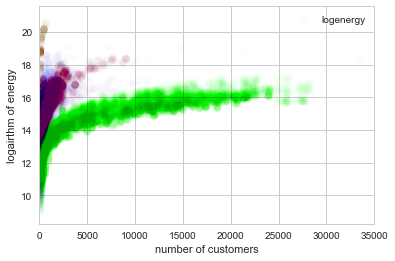

In [7]:
plt.scatter(electricity.totalcustomers, electricity.logenergy, c = electricity.class_factor, cmap=plt.cm.brg, alpha = .01)
plt.xlabel('number of customers')
plt.xlim([0,35000])
plt.ylabel('logairthm of energy')
plt.legend()
plt.show()

It seems that the energy values have different distribution. It is also intuitive, as the number of customers for industrial plant dont hold the same meaning as the number of customers for reidential plants. Therefore, we need to sepeate them, with different names. For example, residential customers can be ``num_residents``, agricultureals can be ``num_farmers``, industrials can be ``num_workers`` and commercials can be ``num_officer``. 

In [8]:
electricity['num_farmers'] = electricity.loc[electricity.customerclass =='Agricultural', 'totalcustomers']
electricity['num_residents'] = electricity.loc[electricity.customerclass =='Residential', 'totalcustomers']
electricity['num_workers'] = electricity.loc[electricity.customerclass =='Industrial', 'totalcustomers']
electricity['num_officers'] = electricity.loc[electricity.customerclass =='Commercial', 'totalcustomers']

# we can easily replace nan values with 0 as they are only available in the num columns
#electricity.fillna(0,inplace=True)

In [9]:
electricity.head()

,zipcode,month,year,customerclass,combined,totalcustomers,totalkwh,logenergy,class_factor,combined_factor,num_farmers,num_residents,num_workers,num_officers
0,93206,2,2013,Agricultural,Y,138,7249627,15.796461,0,0,138.0,NaN,NaN,NaN
1,93206,3,2013,Agricultural,Y,371,20354832,16.828829,0,0,371.0,NaN,NaN,NaN
2,93212,2,2013,Agricultural,Y,213,9971956,16.115287,0,0,213.0,NaN,NaN,NaN
3,93230,2,2013,Agricultural,Y,244,3942702,15.187377,0,0,244.0,NaN,NaN,NaN
4,93245,2,2013,Agricultural,N,334,1008626,13.824100,0,1,334.0,NaN,NaN,NaN


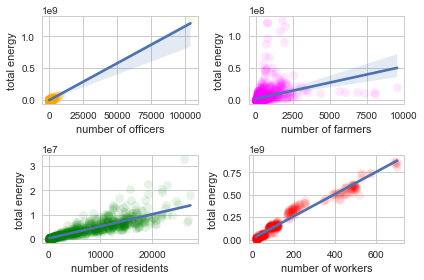

In [10]:

plt.subplot(2,2,1)
sns.regplot(x="num_officers", y="totalkwh", data=electricity[['num_officers','totalkwh']].dropna().sample(1000),
scatter_kws={"s": 80, "alpha":0.09, "color":'orange'},truncate=True, robust=True)
plt.xlabel('number of officers')
plt.ylabel('total energy')

plt.subplot(2,2,2)
sns.regplot(x="num_farmers", y="totalkwh", data=electricity[['num_farmers','totalkwh']].dropna().sample(1000),
scatter_kws={"s": 80, "alpha":0.09, "color":'magenta'},truncate=True, robust=True)
plt.xlabel('number of farmers')
plt.ylabel('total energy')

plt.subplot(2,2,3)
sns.regplot(x="num_residents", y="totalkwh", data=electricity[['num_residents','totalkwh']].dropna().sample(1000),
scatter_kws={"s": 80, "alpha":0.09, "color":'green'},truncate=True, robust=True)
plt.xlabel('number of residents')
plt.ylabel('total energy')

plt.subplot(2,2,4)
sns.regplot(x="num_workers", y="totalkwh", data=electricity[['num_workers','totalkwh']].dropna(),
scatter_kws={"s": 80, "alpha":0.09, "color":'red'},truncate=True, robust=True)
plt.xlabel('number of workers')
plt.ylabel('total energy')


plt.tight_layout()
plt.show()

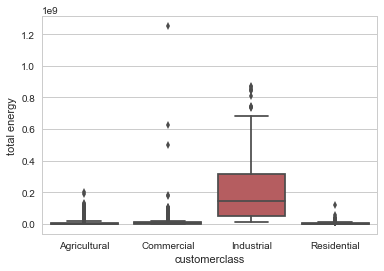

In [11]:
sns.boxplot(x="customerclass", y="totalkwh", data=electricity)
plt.ylabel('total energy')
plt.show()

We notice the obvious difference between the total energy consumption of different customer classes. We also noticed, visually, there is a good relationship between number of users and total energy consumption on each group. This category can be used later for modelling.

Let's impute the nan values with 0.

In [12]:
#electricity.fillna(0, inplace=True)

The goal of this work is to predict the electricity consumption. We would like to add a couple of more features and see if they help with the preidiction.
These components come from the gas usage dataset. Let's import them into one file and perform similar cleaning.

In [13]:
gas_list = []
for indx, file in enumerate(gas_csv_files):
    temp_gas_df = pd.read_csv(file)
    columns_list = temp_gas_df.columns.values # some datasets have uppercase column name
    temp_gas_df.columns = [x.lower() for x in columns_list]
    temp_gas_df.customerclass = temp_gas_df.customerclass.str[5:]
    temp_gas_df.totalthm = temp_gas_df.totalthm.str.replace(",","")
    temp_gas_df.totalthm = pd.to_numeric(temp_gas_df.totalthm)
    temp_gas_df.totalcustomers = temp_gas_df.totalcustomers.str.replace(",","")
    temp_gas_df.totalcustomers = pd.to_numeric(temp_gas_df.totalcustomers)
    temp_gas_df.drop('averagethm', axis = 1, inplace = True)
    gas_list.append(temp_gas_df)


gas = pd.concat(gas_list)
gas = gas.loc[gas.totalcustomers != 0]
gas.reset_index(drop = True, inplace=True)
gas.head()

,zipcode,month,year,customerclass,combined,totalcustomers,totalthm
0,93204.0,1.0,2013.0,Commercial,Y,224.0,68819.0
1,93268.0,1.0,2013.0,Commercial,Y,271.0,57114.0
2,93268.0,2.0,2013.0,Commercial,Y,284.0,40738.0
3,93268.0,3.0,2013.0,Commercial,Y,284.0,32373.0
4,93301.0,1.0,2013.0,Commercial,N,1221.0,399794.0


In [14]:
electricity.drop_duplicates(inplace=True)
gas.drop_duplicates(inplace=True)
gas = gas.groupby(['zipcode', 'month', 'year', 'customerclass', 'combined'], as_index=False).mean()

We are interested in predicting the electricity consumption. Therefore, we are going to join the datasets based on ``electricity`` dataframe.
Before that, in order to no generate duplicate rows, we averaged the gas usag and total customers on the index columns (see the previous cell). We need to take an average between those features so that the data is coherent between both dataframes.

In [15]:
electricity_gas = electricity.merge(gas, on = ['zipcode', 'month', 'year', 'customerclass', 'combined'],
                                    how='left',suffixes=['_elec','_gas'])
print(electricity.shape)
print(gas.shape)
print(electricity_gas.shape)

(70807, 14)
(48484, 7)
(70807, 16)


In [16]:
electricity_gas.head()

,zipcode,month,year,customerclass,combined,totalcustomers_elec,totalkwh,logenergy,class_factor,combined_factor,num_farmers,num_residents,num_workers,num_officers,totalcustomers_gas,totalthm
0,93206,2,2013,Agricultural,Y,138,7249627,15.796461,0,0,138.0,NaN,NaN,NaN,NaN,NaN
1,93206,3,2013,Agricultural,Y,371,20354832,16.828829,0,0,371.0,NaN,NaN,NaN,NaN,NaN
2,93212,2,2013,Agricultural,Y,213,9971956,16.115287,0,0,213.0,NaN,NaN,NaN,NaN,NaN
3,93230,2,2013,Agricultural,Y,244,3942702,15.187377,0,0,244.0,NaN,NaN,NaN,NaN,NaN
4,93245,2,2013,Agricultural,N,334,1008626,13.824100,0,1,334.0,NaN,NaN,NaN,NaN,NaN


Let's perform some visualization data analytics between gas usage and electricity usage

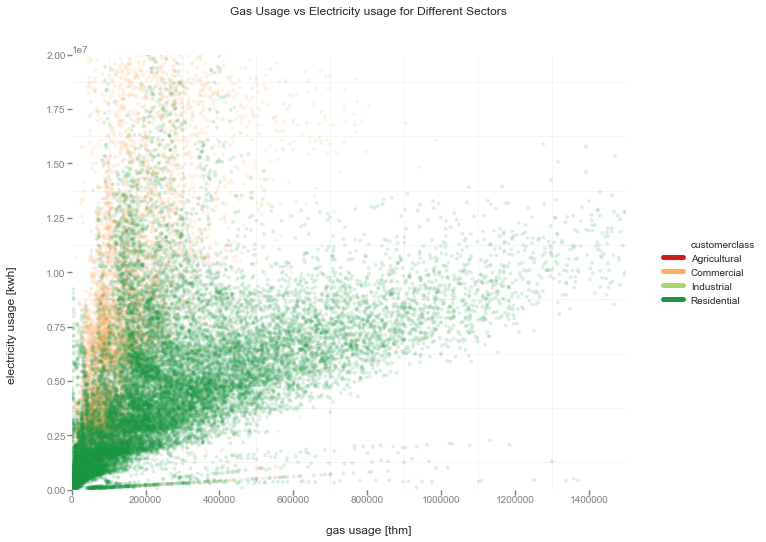

<ggplot: (-9223371876153833991)>

In [17]:
ggplot(aes(x='totalthm', y='totalkwh', color='customerclass'), data=electricity_gas) +\
geom_jitter(size=15, alpha=0.15) +\
theme_bw()+\
labs(x='gas usage [thm]', y = 'electricity usage [kwh]',
                 title = 'Gas Usage vs Electricity usage for Different Sectors')+\
scale_color_brewer(type='div', palette='RdYlGn')+\
xlim(0,0.15e7)+ylim(0,0.2e8)

We can see that by seperating customer classes, we see an almost linear relationship betwen gas usage and electricity usage for residential and commercial units. ** It is noted that the gas consumption is available only for Residential and Commercial sectors**. We can conclude that the gas consmption can be very useful feature.

In [18]:
electricity_gas['gas_residential'] = electricity_gas.loc[electricity_gas.customerclass =='Residential', 'totalthm']
electricity_gas['gas_commercial'] = electricity_gas.loc[electricity_gas.customerclass =='Commercial', 'totalthm']

Finally we need to perform some time-series analysis to better understand how electricity usage has changed overtime.

In [19]:
electricity_gas['date'] = electricity_gas.year.apply(lambda x:str(x)) + "-" +electricity_gas.month.apply(lambda x:str(x))
electricity_gas.date = pd.to_datetime(electricity_gas.date, format='%Y-%m')

In [20]:
monthly_usage = electricity_gas.groupby(['customerclass','date']).totalkwh.mean()

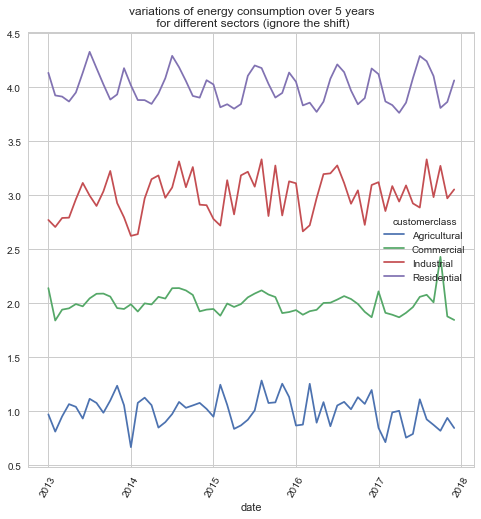

In [21]:
monthly_pivot = monthly_usage.reset_index().pivot(index= 'date', columns = 'customerclass', values = 'totalkwh')
i = 0
for column in monthly_pivot.columns.values:
    monthly_pivot[column] = monthly_pivot[column] / monthly_pivot[column].mean() + i
    i+=1
    
monthly_pivot.plot(figsize = (8,8))
plt.title("variations of energy consumption over 5 years\n for different sectors (ignore the shift)")
plt.xticks(rotation = 60)
plt.show()

Looking at the figure, we can see that residential usage demonstrates periodic behavior, with peaks at summer and winter. Similarly commercial customers demonstrate periodic pattern, with peak at summer and minimum at winter. 
Agricultural and industrial customers show more sporadic behavior. 

## Modelling:

In this work, we are interested in predicting values of energy consumption for each zipcode in different month of the year, based on the customer number, and the amount of gas energy usage.
We are using Gradient Boosting Decision Trees from [``**XGBoost**``](http://xgboost.readthedocs.io/en/latest/) library.

In [22]:
electricity_gas = electricity_gas.drop(axis = 1,columns = ['date','customerclass','combined', 'logenergy'])

In [23]:
electricity_gas.head()

,zipcode,month,year,totalcustomers_elec,totalkwh,class_factor,combined_factor,num_farmers,num_residents,num_workers,num_officers,totalcustomers_gas,totalthm,gas_residential,gas_commercial
0,93206,2,2013,138,7249627,0,0,138.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,93206,3,2013,371,20354832,0,0,371.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,93212,2,2013,213,9971956,0,0,213.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,93230,2,2013,244,3942702,0,0,244.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,93245,2,2013,334,1008626,0,1,334.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
electricity_gas.zipcode = electricity_gas.zipcode.apply(lambda x: int(x))
electricity_gas.month = electricity_gas.month.apply(lambda x: int(x))
electricity_gas.year = electricity_gas.year.apply(lambda x: int(x))

y = electricity_gas.totalkwh
X = electricity_gas.drop(axis=1, columns = 'totalkwh')
X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train ,test_size=0.25)

In [47]:
# fit a random forest model

params = {}
params["objective"] = "reg:linear"
params["eta"] = 0.1
params["min_child_weight"] = 6
params["subsample"] = 0.871
params["colsample_bytree"] = 0.60
params["scale_pos_weight"] = 1.0
params["silent"] = 1
params["max_depth"] = 7


plst = list(params.items())

xgtrain = xgb.DMatrix(X_train, label=y_train)
xgval = xgb.DMatrix(X_val, label=y_val)
xgtest = xgb.DMatrix(X_test, label=y_test)

#train using early stopping and predict
watchlist = [(xgtrain, 'train'),(xgval, 'val')]
num_rounds = 240

model = xgb.train(plst, xgtrain, num_rounds,watchlist, early_stopping_rounds=4)
preds1 = model.predict(xgtest)
for loop in range(100):
    model = xgb.train(plst, xgtrain, num_rounds,watchlist, early_stopping_rounds=4, verbose_eval=False)
    preds1 = preds1 + model.predict(xgtest)
preds = (preds1/101 )

[0]	train-rmse:2.14778e+07	val-rmse:2.02942e+07
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 4 rounds.
[1]	train-rmse:1.96642e+07	val-rmse:1.83508e+07
[2]	train-rmse:1.8138e+07	val-rmse:1.66746e+07
[3]	train-rmse:1.67386e+07	val-rmse:1.51811e+07
[4]	train-rmse:1.54385e+07	val-rmse:1.38635e+07
[5]	train-rmse:1.47842e+07	val-rmse:1.33553e+07
[6]	train-rmse:1.37011e+07	val-rmse:1.22334e+07
[7]	train-rmse:1.27319e+07	val-rmse:1.12666e+07
[8]	train-rmse:1.18816e+07	val-rmse:1.02929e+07
[9]	train-rmse:1.11318e+07	val-rmse:9.50707e+06
[10]	train-rmse:1.04412e+07	val-rmse:8.78208e+06
[11]	train-rmse:1.0093e+07	val-rmse:8.41344e+06
[12]	train-rmse:9.57043e+06	val-rmse:7.8914e+06
[13]	train-rmse:9.0756e+06	val-rmse:7.44385e+06
[14]	train-rmse:8.67408e+06	val-rmse:7.02523e+06
[15]	train-rmse:8.30664e+06	val-rmse:6.62853e+06
[16]	train-rmse:8.13278e+06	val-rmse:6.50066e+06
[17]	train-rmse:7.97794e+06	val-rmse:6.30

In [48]:
print(explained_variance_score(preds,y_test)*100)

97.5189238299311


In [49]:
print("First 5 actual data {}".format(y_test.tolist()[:4]))
print("First 5 actual data {}".format(preds[:4]))

First 5 actual data [10590108, 1497957, 7533014, 1025722]
First 5 actual data [9072705.  1711999.9 9325549.  1133121.9]


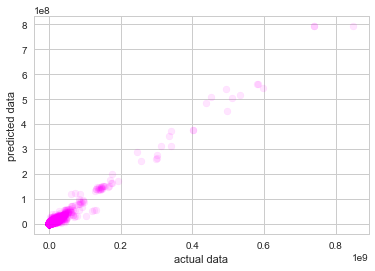

In [50]:
plt.scatter(y_test,preds, alpha = 0.1, color = 'magenta')
plt.xlabel('actual data')
plt.ylabel('predicted data')
plt.show()

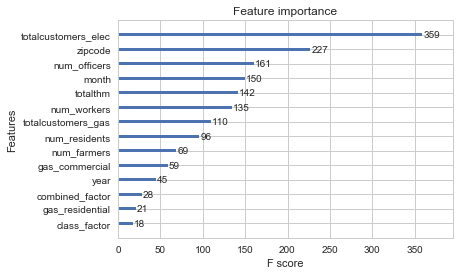

In [51]:
xgb.plot_importance(model)
plt.show()

### Conclusion:
The goal of this notebook is to perform energy prediction on the public data sets from Pacific Gas and Electricl Company. There are 40 historical data set containing monthly gas and electric energy usage from all the zipcodes for 5 years. We would like to predict ``electrical`` energy consumption by different sectors. The following steps are perfomed:

- **EDA** :We used a combination of several visualization tools, namely, ``bokeh``, ``matplotlib``, ``seaborn``, and ``ggplot`` to perform graphical exploratory data analysis on electrical energy data sets. 

- **Feature Engineering** : EDA helped us find several discriminative feature and incorporate them into our model.

- **Modelling** : We used Gradient Boost Decision Trees and averaged 100 models to find the best results. We saw that $97.5\%$ of the variance is explained.


Finally we will export the data out to perform Bayesian prediction on this data in **``R``**.

In [52]:
electricity_gas.to_csv('data.csv')